# Understanding and Mitigating Gradient Flow Pathologies in Physics-Informed Neural Networks

## Ejemplo 1

Considere la ecuación de Helmholtz:
$$\begin{align}
\Delta u(x,y) + k^2 u(x,y)  &= q(x,y), \hspace{1cm} (x,y)\in \Omega := (-1,1)\times (-1,1)\\
u(x,y) &= h(x,y), \hspace{1cm} (x,y) \in \partial \Omega
\end{align}$$

Si la solución viene dada por $u(x,y)=\sin(a_1 \pi x )\sin(a_2 \pi y )$, entonces:
$$q(x,y) = -(a_1 \pi)^2\sin(a_1 \pi x )\sin(a_2 \pi y ) - (a_2 \pi)^2\sin(a_1 \pi x )\sin(a_2 \pi y )  + k^2\sin(a_1 \pi x )\sin(a_2 \pi y ),$$
y además
$$h(x,y) = 0.$$

Para $k=1$, $a_1 = 1$ y $a_2 =4$ se propone una solución pinns $u_{\theta}(x,y)$ que minimiza la función de pérdida:
$$\mathcal{L}(\theta) = \mathcal{L}_r (\theta) + \mathcal{L}_{u_b} (\theta),$$
con $\mathcal{L}_r$ el residual de la ecuacion diferencial parcial y $\mathcal{L}_{u_{b}}$ el residuo de la condición de borde. 

## PINNs

In [1]:
# Librerias
import torch
import torch.autograd as autograd         
import torch.nn as nn        
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm
import time


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        ) 

        self.MSE = nn.MSELoss(reduction ='mean')
        self.loss_hist = {'loss':[], 'pde_loss':[], 'bc_loss':[]}
        self.a_1 = 1
        self.a_2 = 4
        self.k = 1

    def forward(self, x, y):
        X = torch.cat([x, y], 1)
        return self.layers(X)
    
    def loss_PDE(self, x, y):
        u = self.forward(x,y)
        u_x = autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_y = autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_yy = autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

        #q = -(a_1 \pi)^2\sin(a_1 \pi x )\sin(a_2 \pi y ) - (a_2 \pi)^2\sin(a_1 \pi x )\sin(a_2 \pi y )  + k^2\sin(a_1 \pi x )\sin(a_2 \pi y )
        q = - (self.a_1 * torch.pi)**2 * torch.sin(self.a_1 * torch.pi * x) * torch.sin(self.a_2 * torch.pi * y) \
            - (self.a_2 * torch.pi)**2 * torch.sin(self.a_1 * torch.pi * x) * torch.sin(self.a_2 * torch.pi * y) \
            + self.k**2 * torch.sin(self.a_1 * torch.pi * x) * torch.sin(self.a_2 * torch.pi * y)
        
        return self.MSE(u_xx + u_yy + self.k**2 * u, q)
    
    def loss_BC(self, x, y):
        u = self.forward(x, y)
        return self.MSE(u, torch.zeros_like(u))
    
    def loss(self, x, y, x_bc, y_bc):
        loss_pde = self.loss_PDE(x, y)
        loss_bc = self.loss_BC(x_bc, y_bc)
        loss = loss_pde + loss_bc
        return loss, loss_pde, loss_bc
    
    def train(self, x, y, x_bc, y_bc, epochs = 10000, lr = 0.001):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        for epoch in tqdm(range(epochs)):
            optimizer.zero_grad()
            loss, loss_pde, loss_bc = self.loss(x, y, x_bc, y_bc)
            loss.backward()
            optimizer.step()
            self.loss_hist['loss'].append(loss.item())
            self.loss_hist['pde_loss'].append(loss_pde.item())
            self.loss_hist['bc_loss'].append(loss_bc.item())
            if epoch % 1000 == 0:
                print(f'Epoch {epoch}/{epochs} Loss: {loss.item()} Loss PDE: {loss_pde.item()} Loss BC: {loss_bc.item()}')

## Dominio 

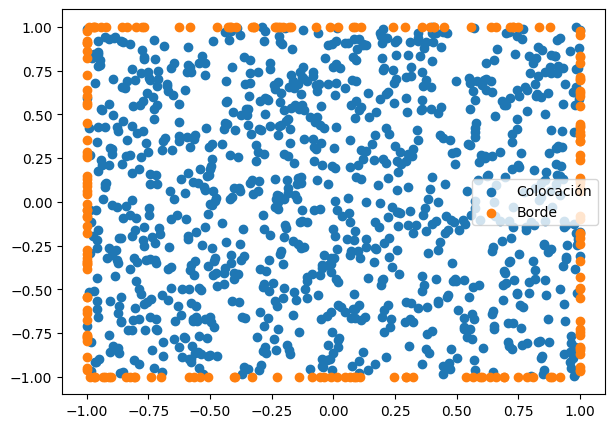

In [5]:
x_min = -1.0
x_max = 1.0
y_min = -1.0
y_max = 1.0

# Puntos de Colocación
n_c = 1000
x_c = torch.rand(n_c, 1) * (x_max - x_min) + x_min
y_c = torch.rand(n_c, 1) * (y_max - y_min) + y_min

x_c.requires_grad = True
y_c.requires_grad = True

# Puntos de Borde
n_b = 50
x_b_1 = torch.rand(n_b, 1) * (x_max - x_min) + x_min
y_b_1 = torch.ones(n_b, 1) * y_min

x_b_2 = torch.rand(n_b, 1) * (x_max - x_min) + x_min
y_b_2 = torch.ones(n_b, 1) * y_max

x_b_3 = torch.ones(n_b, 1) * x_min
y_b_3 = torch.rand(n_b, 1) * (y_max - y_min) + y_min

x_b_4 = torch.ones(n_b, 1) * x_max
y_b_4 = torch.rand(n_b, 1) * (y_max - y_min) + y_min

x_b = torch.cat([x_b_1, x_b_2, x_b_3, x_b_4], 0)
y_b = torch.cat([y_b_1, y_b_2, y_b_3, y_b_4], 0)

# Visualización
plt.figure(figsize=(7,5))
plt.scatter(x_c.detach(), y_c.detach(), label='Colocación')
plt.scatter(x_b, y_b, label='Borde')
plt.legend(loc = 'best')
plt.show()

## Entrenamiento 

In [6]:
net = Net()

In [7]:
net.train(x_c, y_c, x_b, y_b, epochs = 40000, lr = 0.001)

  0%|          | 0/40000 [00:00<?, ?it/s]

Epoch 0/40000 Loss: 6740.39599609375 Loss PDE: 6740.3837890625 Loss BC: 0.012313682585954666
Epoch 1000/40000 Loss: 38.56562042236328 Loss PDE: 18.92451286315918 Loss BC: 19.64110565185547
Epoch 2000/40000 Loss: 7.965452194213867 Loss PDE: 3.013164520263672 Loss BC: 4.952287673950195
Epoch 3000/40000 Loss: 2.9635801315307617 Loss PDE: 1.4307595491409302 Loss BC: 1.5328205823898315
Epoch 4000/40000 Loss: 1.1062183380126953 Loss PDE: 0.7447352409362793 Loss BC: 0.3614831566810608
Epoch 5000/40000 Loss: 0.41799408197402954 Loss PDE: 0.30628636479377747 Loss BC: 0.11170772463083267
Epoch 6000/40000 Loss: 0.2943115830421448 Loss PDE: 0.23381386697292328 Loss BC: 0.0604977123439312
Epoch 7000/40000 Loss: 0.6510064601898193 Loss PDE: 0.6086169481277466 Loss BC: 0.04238952696323395
Epoch 8000/40000 Loss: 0.41778963804244995 Loss PDE: 0.386410653591156 Loss BC: 0.03137898072600365
Epoch 9000/40000 Loss: 0.08498668670654297 Loss PDE: 0.06035546958446503 Loss BC: 0.024631217122077942
Epoch 10000/

## Resultados

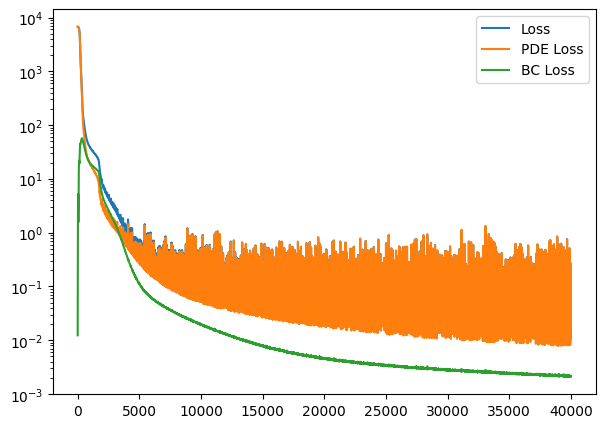

In [8]:
# Grafica Loss
plt.figure(figsize=(7,5))
plt.plot(net.loss_hist['loss'], label='Loss')
plt.plot(net.loss_hist['pde_loss'], label='PDE Loss')
plt.plot(net.loss_hist['bc_loss'], label='BC Loss')
plt.yscale('log')
plt.legend(loc = 'best')
plt.show()

/Users/sebastianjara/miniforge3/envs/tfq/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


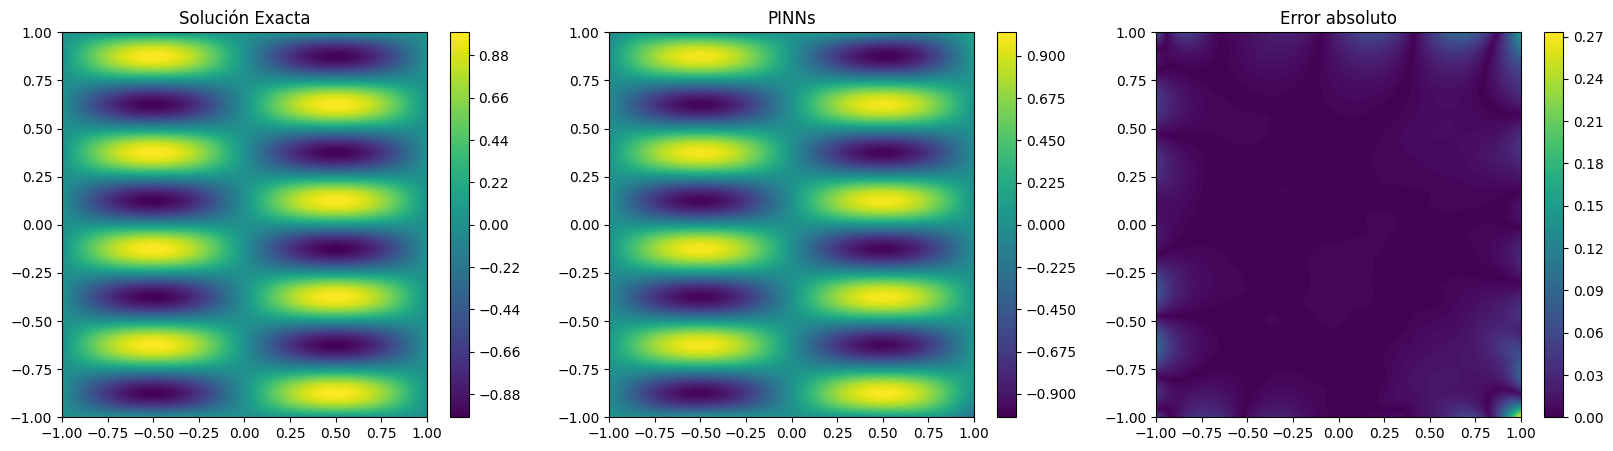

In [9]:
# Grafica Solucion exacta, pinns y error
x = torch.linspace(x_min, x_max, 100)
y = torch.linspace(y_min, y_max, 100)
X, Y = torch.meshgrid(x, y)
U = net.forward(X.reshape(-1, 1), Y.reshape(-1, 1)).reshape(X.shape)

U_exact = torch.sin(net.a_1 * np.pi * X) * torch.sin(net.a_2 * np.pi * Y)
U_exact = U_exact.detach().numpy()

plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.title('Solución Exacta')
plt.contourf(X, Y, U_exact, 100, cmap='viridis')
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title('PINNs')
plt.contourf(X, Y, U.detach().numpy(), 100, cmap='viridis')
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title('Error absoluto')
plt.contourf(X, Y, np.abs(U_exact - U.detach().numpy()), 100, cmap='viridis')
plt.colorbar()
plt.show()


In [10]:
# Calculo del error L2
error = np.sqrt(np.mean((U_exact - U.detach().numpy())**2)) 
print(f'Error L2: {error}')

# Calculo error relativo L2
error = np.sqrt(np.mean((U_exact - U.detach().numpy())**2)) / np.sqrt(np.mean(U_exact**2))
print(f'Error relativo L2: {error}')

Error L2: 0.016624804586172104
Error relativo L2: 0.03358546271920204


### Visualización de Gradientes 

In [50]:
loss_pde_v = net.loss(x_c, y_c, x_b, y_b)[1]
loss_bc_v = net.loss(x_c, y_c, x_b, y_b)[2]

grad_pde_v_w = autograd.grad(loss_pde_v, net.parameters(), create_graph=True, allow_unused=True)
grad_bc_v_w = autograd.grad(loss_bc_v, net.parameters(), create_graph=True, allow_unused=True)

grad_pde_v_w_r = [g.detach().reshape(-1) for g in grad_pde_v_w if g is not None]
grad_bc_v_w_r = [g.detach().reshape(-1) for g in grad_bc_v_w if g is not None]

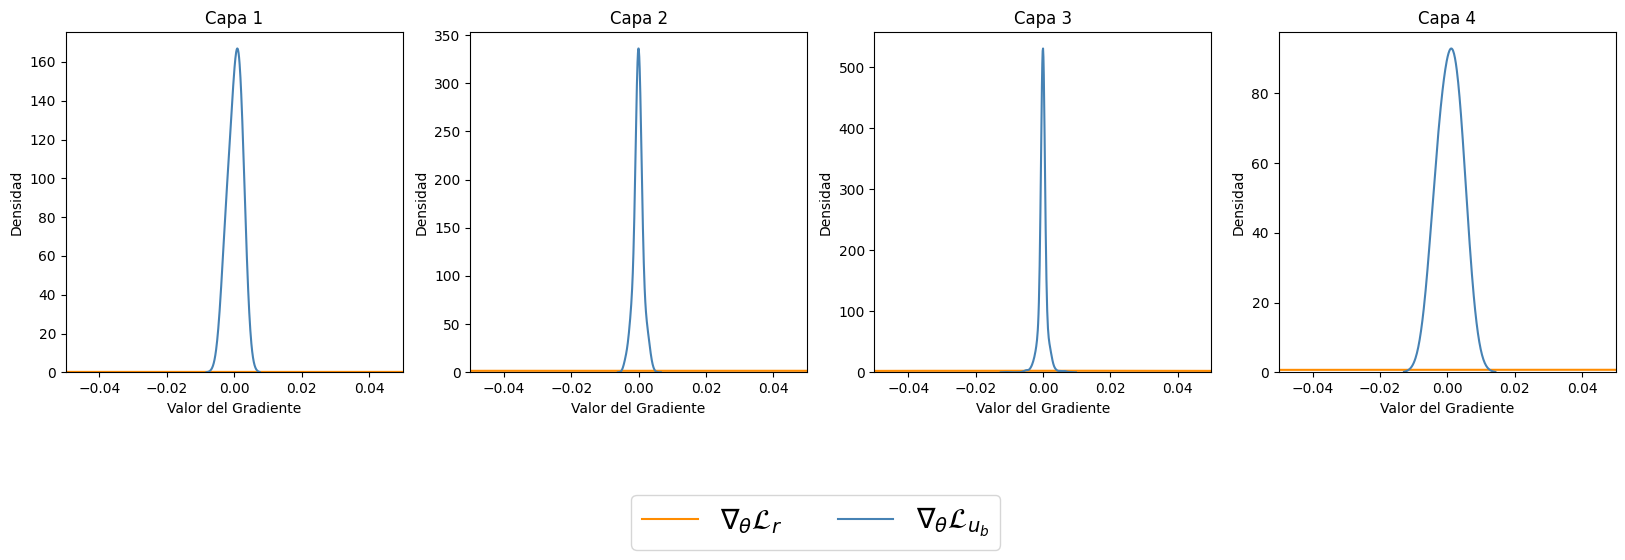

In [51]:
num_columns = len(grad_pde_v_w) // 2
num_rows = 1  # Todos en una sola fila

fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(num_columns*5, 5))

for i, (grad_pde, grad_bc) in enumerate(zip(grad_pde_v_w_r[0:7:2], grad_bc_v_w_r[0:7:2])):
    sns.kdeplot(grad_pde, ax=axes[i], color='#FF8C00', bw_adjust=2.0)  # Color similar al naranja
    sns.kdeplot(grad_bc, ax=axes[i], color='#4682B4', bw_adjust=2.0)    # Color similar al azul

    axes[i].set_title(f'Capa {i+1}')
    axes[i].set_xlim(-0.05, 0.05)
    axes[i].set_xlabel('Valor del Gradiente')
    axes[i].set_ylabel('Densidad')
   #axes[i].set_yscale('log')


# Añadir la leyenda global (solo una vez)
fig.legend(labels=[r'$\nabla_\theta \mathcal{L}_{r}$', r'$\nabla_\theta \mathcal{L}_{u_b}$'],
           loc='center', bbox_to_anchor=(0.5, -0.1), ncol=2, fontsize=20)

# Ajustar el espacio para la leyenda global
plt.subplots_adjust(bottom=0.2)

## PINNs Learning rate annealing

In [34]:
class Net_RA(nn.Module):
    def __init__(self):
        super(Net_RA, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        ) 

        self.MSE = nn.MSELoss(reduction ='mean')
        self.loss_hist = {'loss':[], 'pde_loss':[], 'bc_loss':[]}
        self.a_1 = 1
        self.a_2 = 4
        self.k = 1

        self.hist_lambda = {'Lambda 1': []}
        self.lambda_1 = torch.tensor(1.0, requires_grad=False)
        self.alpha = 0.1

    def forward(self, x, y):
        X = torch.cat([x, y], 1)
        return self.layers(X)
    
    def loss_PDE(self, x, y):
        u = self.forward(x,y)
        u_x = autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_y = autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_yy = autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

        #q = -(a_1 \pi)^2\sin(a_1 \pi x )\sin(a_2 \pi y ) - (a_2 \pi)^2\sin(a_1 \pi x )\sin(a_2 \pi y )  + k^2\sin(a_1 \pi x )\sin(a_2 \pi y )
        q = - (self.a_1 * torch.pi)**2 * torch.sin(self.a_1 * torch.pi * x) * torch.sin(self.a_2 * torch.pi * y) \
            - (self.a_2 * torch.pi)**2 * torch.sin(self.a_1 * torch.pi * x) * torch.sin(self.a_2 * torch.pi * y) \
            + self.k**2 * torch.sin(self.a_1 * torch.pi * x) * torch.sin(self.a_2 * torch.pi * y)
        
        return self.MSE(u_xx + u_yy + self.k**2 * u, q)
    
    def loss_BC(self, x, y):
        u = self.forward(x, y)
        return self.MSE(u, torch.zeros_like(u))
    
    def loss(self, x, y, x_bc, y_bc):
        loss_pde = self.loss_PDE(x, y)
        loss_bc = self.lambda_1 * self.loss_BC(x_bc, y_bc)
        loss = loss_pde + loss_bc
        return loss, loss_pde, loss_bc
    
    def compute_lambda(self,  x, y, x_bc, y_bc):
        loss_pde = self.loss(x, y, x_bc, y_bc)[1]
        loss_bc = self.loss(x, y, x_bc, y_bc)[2]

        grad_pde_w = autograd.grad(loss_pde, self.parameters(), create_graph=True, allow_unused=True)
        grad_bc_w = autograd.grad(loss_bc, self.parameters(), create_graph=True, allow_unused=True)

        flattened_grad_pde_w = torch.cat([g.reshape(-1) for g in grad_pde_w if g is not None])
        flattened_grad_bc_w = torch.cat([g.reshape(-1) for g in grad_bc_w if g is not None])

        max_abs_grad_pde_w = torch.max(torch.abs(flattened_grad_pde_w)).item()
        mean_abs_grad_bc_w = torch.mean(torch.abs(flattened_grad_bc_w)).item()

        lambda_bc_temp = max_abs_grad_pde_w / mean_abs_grad_bc_w

        self.lambda_1 = (1 - self.alpha) * self.lambda_1 + self.alpha * lambda_bc_temp

    def train(self, x, y, x_bc, y_bc, epochs = 10000, lr = 0.001):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        for epoch in tqdm(range(epochs)):
            optimizer.zero_grad()
            loss, loss_pde, loss_bc = self.loss(x, y, x_bc, y_bc)
            loss.backward()
            optimizer.step()
            self.loss_hist['loss'].append(loss.item())
            self.loss_hist['pde_loss'].append(loss_pde.item())
            self.loss_hist['bc_loss'].append(loss_bc.item())

            if (epoch+1) % 10 == 0:
                self.compute_lambda(x, y, x_bc, y_bc)
                self.hist_lambda['Lambda 1'].append(self.lambda_1.item())
                #print(f'Epoch {epoch+1}, Lambda_bc: {self.lambda_1.item()}')

            if epoch % 5000 == 0:
                print(f'Epoch {epoch}/{epochs} Loss: {loss.item()} Loss PDE: {loss_pde.item()} Loss BC: {loss_bc.item()}')

In [35]:
net_ra = Net_RA()

In [36]:
net_ra.train(x_c, y_c, x_b, y_b, epochs = 40000, lr = 0.001)

  0%|          | 0/40000 [00:00<?, ?it/s]

Epoch 0/40000 Loss: 6742.44580078125 Loss PDE: 6742.384765625 Loss BC: 0.060824327170848846
Epoch 5000/40000 Loss: 0.2719312012195587 Loss PDE: 0.21310526132583618 Loss BC: 0.058825939893722534
Epoch 10000/40000 Loss: 0.13544410467147827 Loss PDE: 0.08900273591279984 Loss BC: 0.04644136130809784
Epoch 15000/40000 Loss: 0.0676996111869812 Loss PDE: 0.052413031458854675 Loss BC: 0.015286576934158802
Epoch 20000/40000 Loss: 0.28373000025749207 Loss PDE: 0.23684924840927124 Loss BC: 0.04688076302409172
Epoch 25000/40000 Loss: 0.04047616943717003 Loss PDE: 0.03199772536754608 Loss BC: 0.008478445000946522
Epoch 30000/40000 Loss: 0.028754539787769318 Loss PDE: 0.025468135252594948 Loss BC: 0.0032864052336663008
Epoch 35000/40000 Loss: 0.027120158076286316 Loss PDE: 0.0212874673306942 Loss BC: 0.005832691676914692


## Resultados

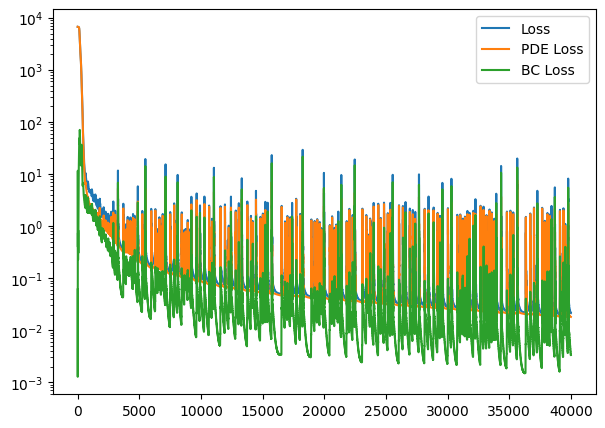

In [37]:
# Grafica Loss
plt.figure(figsize=(7,5))
plt.plot(net_ra.loss_hist['loss'], label='Loss')
plt.plot(net_ra.loss_hist['pde_loss'], label='PDE Loss')
plt.plot(net_ra.loss_hist['bc_loss'], label='BC Loss')
plt.yscale('log')
plt.legend(loc = 'best')
plt.show()

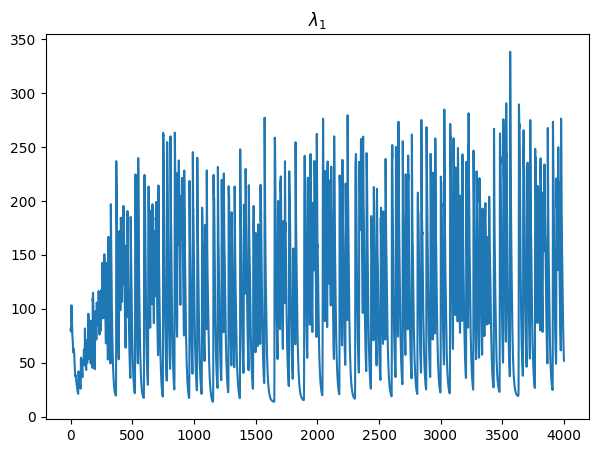

In [38]:
# Gráfica Lambda
plt.figure(figsize=(7,5))
plt.plot(net_ra.hist_lambda['Lambda 1'])
plt.title('$\lambda_{1}$')
plt.show()

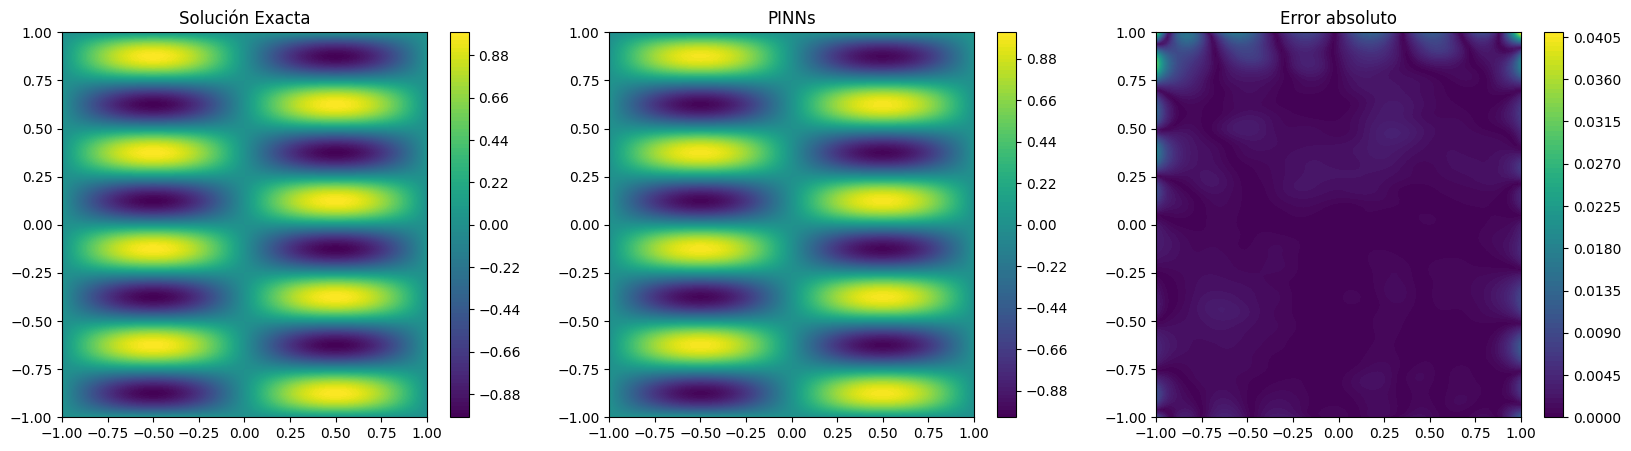

In [39]:
# Grafica Solucion exacta, pinns y error
x = torch.linspace(x_min, x_max, 100)
y = torch.linspace(y_min, y_max, 100)
X, Y = torch.meshgrid(x, y)
U = net_ra.forward(X.reshape(-1, 1), Y.reshape(-1, 1)).reshape(X.shape)

U_exact = torch.sin(net_ra.a_1 * np.pi * X) * torch.sin(net_ra.a_2 * np.pi * Y)
U_exact = U_exact.detach().numpy()

plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.title('Solución Exacta')
plt.contourf(X, Y, U_exact, 100, cmap='viridis')
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title('PINNs')
plt.contourf(X, Y, U.detach().numpy(), 100, cmap='viridis')
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title('Error absoluto')
plt.contourf(X, Y, np.abs(U_exact - U.detach().numpy()), 100, cmap='viridis')
plt.colorbar()
plt.show()

In [40]:
# Calculo del error L2
error = np.sqrt(np.mean((U_exact - U.detach().numpy())**2)) 
print(f'Error L2: {error}')

# Calculo error relativo L2
error = np.sqrt(np.mean((U_exact - U.detach().numpy())**2)) / np.sqrt(np.mean(U_exact**2))
print(f'Error relativo L2: {error}')

Error L2: 0.002883767709136009
Error relativo L2: 0.005825793370604515


### Visualización de Gradientes 

In [48]:
loss_pde_v = net_ra.loss(x_c, y_c, x_b, y_b)[1]
loss_bc_v = net_ra.loss(x_c, y_c, x_b, y_b)[2]

grad_pde_v_w = autograd.grad(loss_pde_v, net_ra.parameters(), create_graph=True, allow_unused=True)
grad_bc_v_w = autograd.grad(loss_bc_v, net_ra.parameters(), create_graph=True, allow_unused=True)

grad_pde_v_w_r = [g.detach().reshape(-1) for g in grad_pde_v_w if g is not None]
grad_bc_v_w_r = [g.detach().reshape(-1) for g in grad_bc_v_w if g is not None]

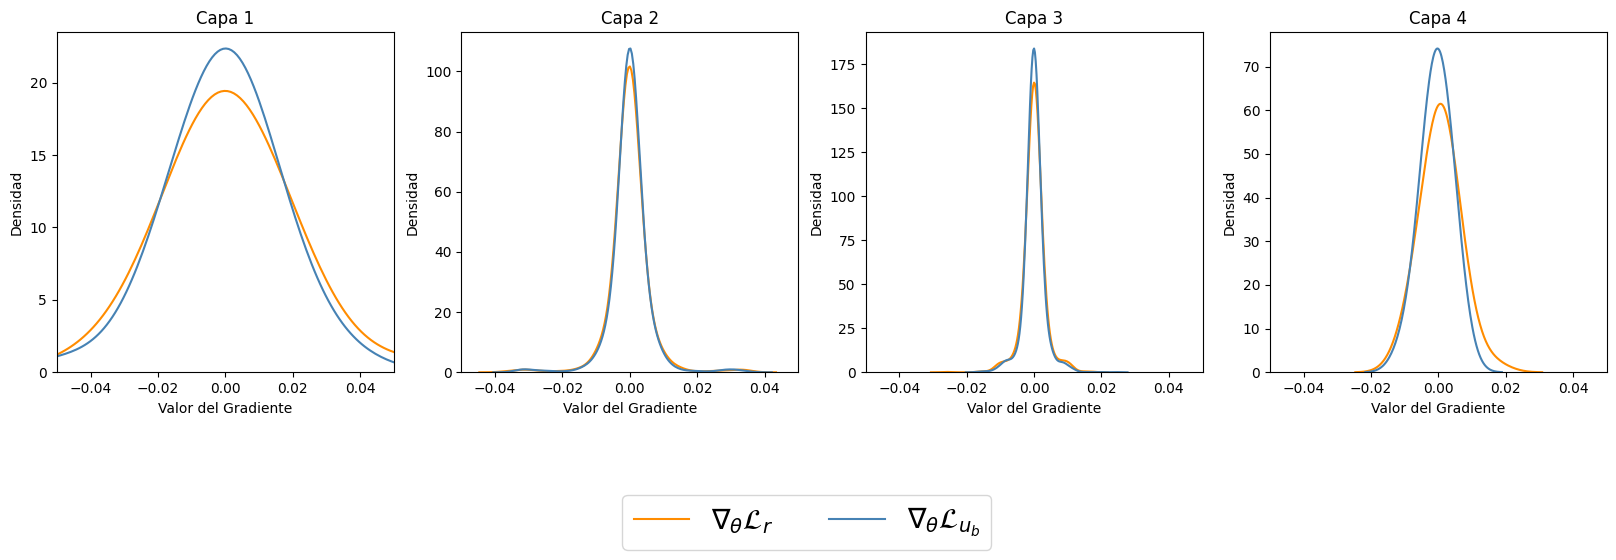

In [49]:
num_columns = len(grad_pde_v_w) // 2
num_rows = 1  # Todos en una sola fila

fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(num_columns*5, 5))

for i, (grad_pde, grad_bc) in enumerate(zip(grad_pde_v_w_r[0:7:2], grad_bc_v_w_r[0:7:2])):
    sns.kdeplot(grad_pde, ax=axes[i], color='#FF8C00', bw_adjust=2.0)  # Color similar al naranja
    sns.kdeplot(grad_bc, ax=axes[i], color='#4682B4', bw_adjust=2.0)    # Color similar al azul

    axes[i].set_title(f'Capa {i+1}')
    axes[i].set_xlim(-0.05, 0.05)
    axes[i].set_xlabel('Valor del Gradiente')
    axes[i].set_ylabel('Densidad')
   #axes[i].set_yscale('log')


# Añadir la leyenda global (solo una vez)
fig.legend(labels=[r'$\nabla_\theta \mathcal{L}_{r}$', r'$\nabla_\theta \mathcal{L}_{u_b}$'],
           loc='center', bbox_to_anchor=(0.5, -0.1), ncol=2, fontsize=20)

# Ajustar el espacio para la leyenda global
plt.subplots_adjust(bottom=0.2)